<a href="https://colab.research.google.com/github/Zouu-X/DL_ass2/blob/zoe-T1/ass2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Fill in your name]
### Member 2: [Fill in your name]
### Member 3: [Fill in your name]

We need to install some specific libraries. The cell below installs torch_geometric for torch 2.6.0+cu124. In case the current version of torch is different, check [here](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) to see which versions (of both libraries) you should install. You might also need to install an old version of torch from [here](https://pytorch.org/get-started/previous-versions/)

**Note:** Do not install pyg_lib from the optional dependencies

In [ ]:
!pip show torch

Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


In [ ]:
!pip install rdkit
!pip install torch_geometric
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.6.0+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 112.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.0 MB/s eta 0:00:00


In [ ]:
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from collections import Counter
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

In [ ]:
## For colab
from google.colab import drive
drive.mount('/content/drive')
dataset_dir = "/content/drive/MyDrive/ColabNotebooks/ass2/ass2_data"

Mounted at /content/drive


In [ ]:
pos_data_path = os.path.join(dataset_dir, "pos_data.pkl")
type_data_path = os.path.join(dataset_dir, "type_data.pkl")
smiles_data_path = os.path.join(dataset_dir, "smiles.pkl")
data_split_path = os.path.join(dataset_dir, "data_split.npz")
formation_energy_path = os.path.join(dataset_dir, "formation_energy.npz")
with open(pos_data_path, 'rb') as f:
    pos_data = pickle.load(f)

with open(type_data_path, 'rb') as f:
    type_data = pickle.load(f)

with open(smiles_data_path, 'rb') as f:
    smiles_data = pickle.load(f)

data_split = np.load(data_split_path)

train_idxes = data_split['train_idx']
test_idxes = data_split['test_idx']

train_idxes, val_idxes = train_test_split(
    train_idxes, test_size=0.1, random_state=42
)
formation_energy = np.load(formation_energy_path)

fe = formation_energy['y'] # normalized formation energy
fe_tensor = torch.tensor(fe, dtype=torch.float32) # Convert to tensor
mu = formation_energy['mu']
std = formation_energy['sigma']
print("Target tensor shape:", fe_tensor.shape)
print(f"Train size: {len(train_idxes)} | Val size: {len(val_idxes)} | Test size: {len(test_idxes)}")
print("Example target (train):", fe_tensor[train_idxes[0]])

Target tensor shape: torch.Size([129012])
Train size: 107110 | Val size: 11902 | Test size: 10000
Example target (train): tensor(-0.4042)


In [ ]:
# shapes of lists
print("Length of data")
print(f"pos_data: {len(pos_data)}, type_data: {len(type_data)}, smiles: {len(smiles_data)}")
print("Idxes")
print(f"train: {len(train_idxes)}, test: {len(test_idxes)}, sum: {len(train_idxes) + len(test_idxes)}")

Length of data
pos_data: 129012, type_data: 129012, smiles: 129012
Idxes
train: 107110, test: 10000, sum: 117110


In [ ]:
def at_number_to_atom_name(at_number):
    if at_number == 6:
        return 'C'
    elif at_number == 1:
        return 'H'
    elif at_number == 7:
        return 'N'
    elif at_number == 8:
        return 'O'
    elif at_number == 9:
        return 'F'
    elif at_number == 16:
        return 'S'
    else:
        return 'Unknown'

def inspect_structure(idx):
    smile = smiles_data[idx]
    pos = pos_data[idx]
    typ = type_data[idx]

    header = f"{'Atom':^5}│{'Number':^6}│{'x':^10}│{'y':^10}│{'z':^10}"
    line   = "─────┼──────┼──────────┼──────────┼──────────"
    print(header)
    print(line)

    for atom_num, (x, y, z) in zip(typ, pos):
        atom_sym = at_number_to_atom_name(atom_num)
        print(f"{atom_sym:^5}│{atom_num:^6}│{x:>10.3f}│{y:>10.3f}│{z:>10.3f}")
    print("")
    print("")
    print(f'SMILE: {smile}')
    print("")
    print("")
    print(f'Formation Energy: {fe[idx]*std + mu:.3f}')
    print(f'Formation Energy (normalized): {fe[idx]:.5f}')
    mol = Chem.MolFromSmiles(smile)
    if mol:
        # RDKit prefers 2‑D coordinates for nice depictions
        Chem.AllChem.Compute2DCoords(mol)
        img = Draw.MolToImage(mol, size=(300, 300))

        # Display with matplotlib (works both in notebooks and scripts)
        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.imshow(img)
        plt.show()

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  C  │  6   │    -0.013│     1.086│     0.008
  H  │  1   │     0.002│    -0.006│     0.002
  H  │  1   │     1.012│     1.464│     0.000
  H  │  1   │    -0.541│     1.447│    -0.877
  H  │  1   │    -0.524│     1.438│     0.906


SMILE: C


Formation Energy: -17.172
Formation Energy (normalized): 5.72327


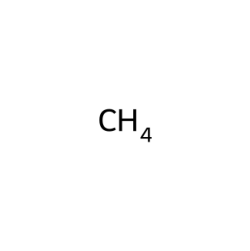

In [ ]:
# methane
# Note how methane has a relatively high formation energy (compared to QM9)
# This correlates with lower thermodynamic stability and higher reactivity
# For example, methane readily burns in oxygen (CH₄ + 2O₂ → CO₂ + 2H₂O)
inspect_structure(0)

Atom │Number│    x     │    y     │    z     
─────┼──────┼──────────┼──────────┼──────────
  O  │  8   │     0.010│     0.659│     1.200
  C  │  6   │    -0.014│     1.505│     0.347
  C  │  6   │    -1.287│     2.094│    -0.288
  C  │  6   │    -0.854│     3.374│    -0.998
  C  │  6   │    -0.809│     4.669│    -0.170
  N  │  7   │    -0.043│     4.344│     1.056
  C  │  6   │     0.679│     4.690│    -0.191
  C  │  6   │     0.737│     3.396│    -1.020
  C  │  6   │     1.225│     2.129│    -0.322
  H  │  1   │    -1.673│     1.353│    -1.000
  H  │  1   │    -2.049│     2.235│     0.482
  H  │  1   │    -1.306│     3.520│    -1.979
  H  │  1   │    -1.521│     5.485│    -0.175
  H  │  1   │    -0.046│     5.166│     1.656
  H  │  1   │     1.369│     5.524│    -0.215
  H  │  1   │     1.158│     3.554│    -2.013
  H  │  1   │     2.004│     2.291│     0.426
  H  │  1   │     1.611│     1.398│    -1.045


SMILE: O=C1C[C@@H]2[C@H](C1)[C@@H]1N[C@H]21


Formation Energy: -77.697
Format

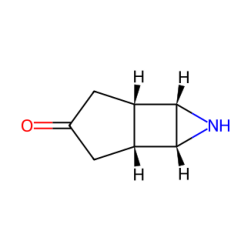

In [ ]:
# random structure
inspect_structure(np.random.choice(range(len(smiles_data))))

## Task 1

In [ ]:
# Task 1, Tokenize character by character

all_chars = [char for smile in smiles_data for char in smile] # Flattens chars
vocab = sorted(set(all_chars))
vocab = ['<PAD>', '<UNK>'] + vocab
token_to_idx = {token: idx for idx, token in enumerate(vocab)}

def smiles_to_sequence(smile):
    return [token_to_idx.get(char, token_to_idx['<UNK>']) for char in smile]

tokenized = [smiles_to_sequence(s) for s in smiles_data]
max_len = max(len(seq) for seq in tokenized)
padded = torch.nn.utils.rnn.pad_sequence(
    [torch.tensor(seq) for seq in tokenized],
    batch_first=True,
    padding_value=token_to_idx['<PAD>']
)
print(f"Vocab size: {len(vocab)}")
print(f"Max SMILES length: {max_len}")
print("Example (index 0):", padded[0])

Vocab size: 26
Max SMILES length: 62
Example (index 0): tensor([15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0])


In [ ]:
class SmilesDataset(Dataset):
  def __init__(self, smiles_tensor, energy_tensor, indicies):
    self.smiles_tensor = smiles_tensor[indicies]
    self.energy_tensor = energy_tensor[indicies]

  def __len__(self):
    return len(self.energy_tensor)

  def __getitem__(self, idx):
      return self.smiles_tensor[idx], self.energy_tensor[idx]

train_dataset = SmilesDataset(padded, fe_tensor, train_idxes)
val_dataset   = SmilesDataset(padded, fe_tensor, val_idxes)
test_dataset  = SmilesDataset(padded, fe_tensor, test_idxes)

BS = 128
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BS)
test_loader = DataLoader(test_dataset, batch_size=BS)

print("Train batches:", len(train_loader))
print("Validation batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 837
Validation batches: 93
Test batches: 79


In [ ]:
class SMILESEnergyPredictor(nn.Module):
  def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=token_to_idx['<PAD>'])
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, 1)
  def forward(self, x):
    emb = self.embedding(x)
    output, (h_n, _) = self.lstm(emb)
    out = self.fc(h_n.squeeze(0))
    return out.squeeze(1)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SMILESEnergyPredictor(vocab_size=len(token_to_idx)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_model(model, train_loader, val_loader, epochs=10):
  best_val_loss = float('inf')
  for epoch in range(epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    for x_batch, y_batch in train_loader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)

      optimizer.zero_grad()
      preds = model(x_batch)
      loss = criterion(preds, y_batch)
      loss.backward()
      optimizer.step()

      train_loss += loss.item() * x_batch.size(0)
      pbar.set_postfix(train_loss=loss.item())
    train_loss /= len(train_loader.dataset)

    # Val
    model.eval()
    val_loss = 0
    with torch.no_grad():
      for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        val_loss += loss.item() * x_batch.size(0)
    val_loss /= len(val_loader.dataset)
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/ass2/models/smiles_model.pth")
    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")





In [ ]:
train_model(model, train_loader, val_loader, epochs=20)

Epoch 1/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  1 | Train Loss: 1.0034 | Val Loss: 1.0109


Epoch 2/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  2 | Train Loss: 0.9226 | Val Loss: 0.2676


Epoch 3/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  3 | Train Loss: 0.0311 | Val Loss: 0.0060


Epoch 4/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  4 | Train Loss: 0.0053 | Val Loss: 0.0045


Epoch 5/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  5 | Train Loss: 0.0045 | Val Loss: 0.0033


Epoch 6/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  6 | Train Loss: 0.0039 | Val Loss: 0.0065


Epoch 7/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  7 | Train Loss: 0.0035 | Val Loss: 0.0037


Epoch 8/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  8 | Train Loss: 0.0033 | Val Loss: 0.0035


Epoch 9/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch  9 | Train Loss: 0.0029 | Val Loss: 0.0028


Epoch 10/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.0031 | Val Loss: 0.0030


Epoch 11/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.0025 | Val Loss: 0.0023


Epoch 12/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.0024 | Val Loss: 0.0020


Epoch 13/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.0024 | Val Loss: 0.0021


Epoch 14/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch 14 | Train Loss: 0.0023 | Val Loss: 0.0034


Epoch 15/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch 15 | Train Loss: 0.0024 | Val Loss: 0.0019


Epoch 16/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch 16 | Train Loss: 0.0020 | Val Loss: 0.0035


Epoch 17/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch 17 | Train Loss: 0.0021 | Val Loss: 0.0018


Epoch 18/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch 18 | Train Loss: 0.0019 | Val Loss: 0.0025


Epoch 19/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch 19 | Train Loss: 0.0019 | Val Loss: 0.0018


Epoch 20/20:   0%|          | 0/837 [00:00<?, ?it/s]

Epoch 20 | Train Loss: 0.0018 | Val Loss: 0.0023


In [ ]:
# model = SMILESEnergyPredictor(vocab_size=len(token_to_idx)).to(device)
# model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/ass2/models/smiles_model.pth"))
model.eval()

# 2) Prepare loss functions
mse_loss = nn.MSELoss(reduction="mean")
mae_loss = nn.L1Loss(reduction="mean")

# 3) Loop over test set
all_preds = []
all_targets = []

with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        preds = model(x_batch)

        all_preds.append(preds.cpu())
        all_targets.append(y_batch.cpu())

# 4) Concatenate
preds = torch.cat(all_preds)    # shape [N]
targets = torch.cat(all_targets)

# 5) Metrics in normalized space
mse_norm = mse_loss(preds, targets).item()
mae_norm = mae_loss(preds, targets).item()

print(f"Test (normalized) →  MSE: {mse_norm:.5f} | MAE: {mae_norm:.5f}")

# 6) Denormalize to actual formation energies
preds_actual   = preds * std + mu
targets_actual = targets * std + mu

mse_actual = mse_loss(preds_actual, targets_actual).item()
mae_actual = mae_loss(preds_actual, targets_actual).item()

print(f"Test (actual)     →  MSE: {mse_actual:.5f} | MAE: {mae_actual:.5f}")

Test (normalized) →  MSE: 0.00219 | MAE: 0.03310
Test (actual)     →  MSE: 0.23312 | MAE: 0.34131


<ipython-input-13-3396910959>:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  preds_actual   = preds * std + mu
<ipython-input-13-3396910959>:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  targets_actual = targets * std + mu


In [ ]:
# Geometric

max_atom = max(max(types) for types in type_data)
num_atom_types = max_atom + 1

def make_graph(i):
    pos = torch.tensor(pos_data[i], dtype=torch.float)
    atom_nums = torch.tensor(type_data[i], dtype=torch.long)
    y = fe_tensor[i].unsqueeze(0)

    return Data(z=atom_nums, pos=pos, y=y)



train_graphs = [make_graph(i) for i in train_idxes]
val_graphs   = [make_graph(i) for i in val_idxes]
test_graphs  = [make_graph(i) for i in test_idxes]


from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_graphs,   batch_size=32)
test_loader  = DataLoader(test_graphs,  batch_size=32)

In [ ]:
from torch_geometric.nn import NNConv, global_mean_pool, SchNet

class GeometricEnergyPredictor(nn.Module):
    def __init__(self, cutoff=5.0, hidden_channels=128,
                 num_filters=128, num_interactions=6,
                 num_gaussians=32):
        super().__init__()
        self.schnet = SchNet(hidden_channels=hidden_channels,
                             num_filters=num_filters,
                             num_interactions=num_interactions,
                             num_gaussians=num_gaussians,
                             cutoff=cutoff)
    def forward(self, data):
        # returns shape [batch_size, 1] or [batch_size]
        return self.schnet(data.z, data.pos, data.batch).squeeze(1)


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_g = GeometricEnergyPredictor(
    cutoff=5.0, hidden_channels=128,
    num_filters=128, num_interactions=6,
    num_gaussians=32
).to(device)
criterion = nn.MSELoss()

def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)
    best_val = float('inf')
    train_losses, val_losses = [], []

    for epoch in range(1, epochs+1):
        # --- TRAIN ---
        model.train()
        tot_train = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            y   = data.y.view(-1)
            loss= criterion(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            tot_train += loss.item() * data.num_graphs
        avg_train = tot_train / len(train_loader.dataset)
        train_losses.append(avg_train)

        # --- VALID ---
        model.eval()
        tot_val = 0
        with torch.no_grad():
            for data in val_loader:
                data = data.to(device)
                out  = model(data)
                y    = data.y.view(-1)
                tot_val += criterion(out, y).item() * data.num_graphs
        avg_val = tot_val / len(val_loader.dataset)
        val_losses.append(avg_val)

        # LR sched & checkpoint
        scheduler.step(avg_val)
        if avg_val < best_val:
            best_val = avg_val
            torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/ass2/models/geo_model.pth")

        print(f"Epoch {epoch} — Train: {avg_train:.4f} | Val: {avg_val:.4f}")

    # Plot losses
    import matplotlib.pyplot as plt
    plt.plot(train_losses, label='Train'); plt.plot(val_losses, label='Val')
    plt.legend(); plt.show()


cuda


Epoch 1 — Train: 0.1487 | Val: 0.0643
Epoch 2 — Train: 0.0351 | Val: 0.0363
Epoch 3 — Train: 0.0214 | Val: 0.0139
Epoch 4 — Train: 0.0144 | Val: 0.0122
Epoch 5 — Train: 0.0113 | Val: 0.0055
Epoch 6 — Train: 0.0078 | Val: 0.0218
Epoch 7 — Train: 0.0077 | Val: 0.0062
Epoch 8 — Train: 0.0069 | Val: 0.0068
Epoch 9 — Train: 0.0056 | Val: 0.0052
Epoch 10 — Train: 0.0059 | Val: 0.0029
Epoch 11 — Train: 0.0044 | Val: 0.0060
Epoch 12 — Train: 0.0041 | Val: 0.0042
Epoch 13 — Train: 0.0040 | Val: 0.0026
Epoch 14 — Train: 0.0040 | Val: 0.0022
Epoch 15 — Train: 0.0034 | Val: 0.0053
Epoch 16 — Train: 0.0032 | Val: 0.0060
Epoch 17 — Train: 0.0038 | Val: 0.0018
Epoch 18 — Train: 0.0035 | Val: 0.0023
Epoch 19 — Train: 0.0029 | Val: 0.0023
Epoch 20 — Train: 0.0033 | Val: 0.0023


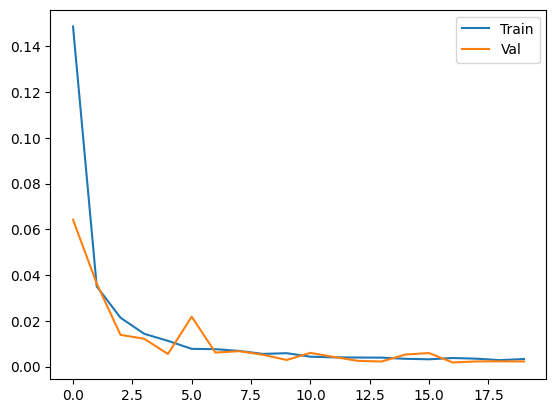

In [ ]:
train_model(model_g, train_loader, val_loader, epochs=20)

In [ ]:
# model_g.load_state_dict(torch.load("geo_model.pth"))
# model_g.eval()

# accumulate
preds, targs = [], []
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model_g(data).cpu()
        preds.append(out)
        targs.append(data.y.cpu())

preds = torch.cat(preds)
targs = torch.cat(targs)

mse = criterion(preds, targs).item()
mae = nn.L1Loss()(preds, targs).item()
print(f"Geo Test (normalized) → MSE: {mse:.5f} | MAE: {mae:.5f}")

# denormalize
preds_act = preds * std + mu
targs_act = targs * std + mu
print(f"Geo Test (actual)     → MSE: {nn.MSELoss()(preds_act, targs_act):.5f} | MAE: {nn.L1Loss()(preds_act, targs_act):.5f}")


Geo Test (normalized) → MSE: 0.00210 | MAE: 0.03862
Geo Test (actual)     → MSE: 0.22323 | MAE: 0.39822


<ipython-input-21-84531027>:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  preds_act = preds * std + mu
<ipython-input-21-84531027>:22: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  targs_act = targs * std + mu


## Task 2

## Task 3

In [ ]:
def is_valid_smiles(smiles):
    if smiles is None:
        return False
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

def canonicalize(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
        return 'None'
    except:
        return 'None'

In [ ]:
canonicalize("COO"), canonicalize("O(C)O")

In [ ]:
is_valid_smiles("COO"), is_valid_smiles("O(C)O"), is_valid_smiles("C##")